# Activity: Evaluation of Bandit Problem Algorithms
In this activity we'll continue our discussion [of multi-armed bandit problems](https://en.wikipedia.org/wiki/Multi-armed_bandit) and look at the performance of the explore first, $\epsilon$-greedy and UCB1 algorithms on a simple stochastic bandit problem.

The objective of the bandit algorithm is to discover the action (or "arm") that provides the highest expected reward. The arms in our case will be Beta distributions with different parameters

> __Learning Objectives.__
>
> By the end of this activity, you will be able to:
> * __Implement bandit algorithms__: Build and execute explore-first, epsilon-greedy, and UCB1 algorithms for solving multi-armed bandit problems with stochastic reward distributions.
> * __Evaluate algorithm performance__: Compute empirical regret metrics and compare the actual performance of different bandit algorithms against theoretical regret bounds.
> * __Analyze theoretical vs. empirical results__: Compare the theoretical regret guarantees of bandit algorithms with their empirical performance on simulated problems to understand practical effectiveness.

Let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [1]:
include(joinpath(@__DIR__, "Include-solution.jl")); # include the Include.jl file

In addition to standard Julia libraries, we'll also use [the `VLDataScienceMachineLearningPackage.jl` package](https://github.com/varnerlab/VLDataScienceMachineLearningPackage.jl). Check out [the documentation](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/) for more information on the functions, types, and data used in this material.

### Implementation
First, let's implement the `world(...)` function. This function takes the action $a$ from our agent and returns the reward associated with choosing this action, i.e., $r\sim\mathcal{D}_{a}$. We'll use [a Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) to model the rewards.

A [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) has two parameters $\left(\alpha,\beta\right)$ which determine its shape. The expectation of a [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) is given by: $\alpha/(\alpha+\beta)$.

In [2]:
function world(a::Int64)::Float64

    # initialize -
    model = Dict{Int, Beta}();
    model[1] = Beta(2.0,2.0); # action 1
    model[2] = Beta(10.0,2.0); # action 2
    model[3] = Beta(2.0,10.0); # action 3
    model[4] = Beta(6.0,20.0); # action 4
    model[5] = Beta(20.0,6.0); # action 5
    model[6] = Beta(20.0,10.0); # action 6
    model[7] = Beta(10.0,20.0); # action 7

    # return -
    return model[a] |> d-> rand(d);
end;

Which arm has the highest expected reward? (only the world knows this answer, the bandits do not!)

In [3]:
let

    # initialize -
    number_of_arms = 7;
    model = Dict{Int, Beta}();
    df = DataFrame();

    # same as the world model -
    model[1] = Beta(2.0,2.0); # action 1
    model[2] = Beta(10.0,2.0); # action 2
    model[3] = Beta(2.0,10.0); # action 3
    model[4] = Beta(6.0,20.0); # action 4
    model[5] = Beta(20.0,6.0); # action 5
    model[6] = Beta(20.0,10.0); # action 6
    model[7] = Beta(10.0,20.0); # action 7

    for a ∈ 1:number_of_arms
        
        d = model[a];
        p = params(d);
        mean_reward = mean(d);
        sd_reward = std(d);
        α = p[1]
        β = p[2];

        row_df = (
            action = a,
            alpha = α,
            beta = β,
            mean_reward = mean_reward,
            sd_reward = sd_reward,
        );

        push!(df, row_df);
    end

    pretty_table(
         df;
         backend = :text,
         table_format = TextTableFormat(borders = text_table_borders__compact)
    );

end

 -------- --------- --------- ------------- -----------
  action     alpha      beta   mean_reward   sd_reward 
   Int64   Float64   Float64       Float64     Float64 
 -------- --------- --------- ------------- -----------
       1       2.0       2.0           0.5    0.223607
       2      10.0       2.0      0.833333    0.103362
       3       2.0      10.0      0.166667    0.103362
       4       6.0      20.0      0.230769    0.081084
       5      20.0       6.0      0.769231    0.081084
       6      20.0      10.0      0.666667   0.0846668
       7      10.0      20.0      0.333333   0.0846668
 -------- --------- --------- ------------- -----------


So the winner is going to be the arm with the highest expected reward, which is controlled by the parameters of the Beta distribution (in this case arm 2).

The code block below shows how we plotted sample Beta distributions for different parameter choices:

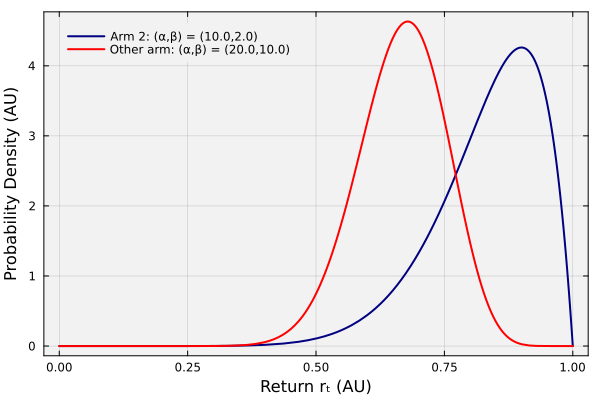

In [4]:
let
    p = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent); 
    α,β = 10.0, 2.0;
    d = Beta(α,β);
    α₁,β₁ = 20.0, 10.0;
    other_arm_d = Beta(α₁,β₁);
    
    plot!(d, lw=2, c=:navy, label="Arm 2: (α,β) = ($(α),$(β))")
    plot!(other_arm_d, lw=2, c=:red, label="Other arm: (α,β) = ($(α₁),$(β₁))")
    xlabel!("Return rₜ (AU)", fontsize=18)
    ylabel!("Probability Density (AU)", fontsize=18)
end

### Constants
Finally, let's set some constants we'll use in the subsequent tasks. See the comment beside the value for a description of what it is, its permissible values, etc.

In [5]:
K = 7; # number of arms for the bandit
T = 5000; # number of rounds for each decision task

___

## Task 1: Evaluation of Algorithms
In this task, we'll implement and run the explore first, $\epsilon$-greedy, and the UCB1 algorithms on our example `K`-arm bandit problem. We'll explain each algorithm and look at its outputs.

Let's start with the explore first algorithm.

### Explore First Algorithm
The agent has $K$ arms, $\mathcal{A} = \left\{1,2,\dots,K\right\}$, and the total number of rounds is $T$. The agent uses the following algorithm to choose which arm to pull during each round:
1. _Initialization_: For each arm $a\in\mathcal{A}$, set $N_{a} = (T/K)^{2/3}\cdot\mathcal{O}\left(\log{T}\right)^{1/3}$ (the number of times we try action $a$).
2. _Exploration_: Play each arm $a\in\mathcal{A}$ for $N_{a}$ rounds and record the rewards. After the exploration phase, select the arm $a^{\star}$ with the highest mean reward (break ties arbitrarily).

__Theorem__: The _expected_ regret over $T$ rounds of the _uniform exploration_ algorithm is bounded by $\mathbb{E}\left[R(T)\right]\leq{T}^{2/3}\times\mathcal{O}\left(K\cdot\log{T}\right)^{1/3}$, where $K$ is the number of arms, $T$ is the total number of rounds and $N = (T/K)^{2/3}\cdot\mathcal{O}\left(\log{T}\right)^{1/3}$ is the number of rounds in the exploration phase for each action (choice).

#### Implementation
We've created a custom type for each algorithm with information about the algorithm or problem. In this implementation, we are only storing the number of arms. We then pass that model to a solve method that runs the task.

We create an [instance of the `MyExploreFirstAlgorithmModel` type](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/bandit/#VLDataScienceMachineLearningPackage.MyExploreFirstAlgorithmModel) which holds the number of arms `K` using [a `build(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/factory/). To solve the problem, we pass the model [to the `solve(...)` method](src/Bandit.jl), which returns the output from the game.

__Output__: Each of [the `solve(...)` methods](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/bandit/#VLDataScienceMachineLearningPackage.solve-Tuple{AbstractBanditAlgorithmModel}) returns a results array $\mathbf{U}$ holding the records of the game. The rows of the array are the turns of the decision task, while each column corresponds to the action $a\in\mathcal{A}$. If $u_{t,a}>0$, then action $a$ was chosen in round $t$, and $u_{t,a}$ is the reward received for taking action $a$.

In [6]:
results_explore_first = let

    m = build(MyExploreFirstAlgorithmModel, (
        K = K, # number of arms
    ));
    
    results = solve(m, T = T, world = world);
    results;
end

5000×7 Matrix{Float64}:
 0.546282  0.0       0.0  0.0  0.0  0.0  0.0
 0.583755  0.0       0.0  0.0  0.0  0.0  0.0
 0.33716   0.0       0.0  0.0  0.0  0.0  0.0
 0.166321  0.0       0.0  0.0  0.0  0.0  0.0
 0.425898  0.0       0.0  0.0  0.0  0.0  0.0
 0.874117  0.0       0.0  0.0  0.0  0.0  0.0
 0.483208  0.0       0.0  0.0  0.0  0.0  0.0
 0.63577   0.0       0.0  0.0  0.0  0.0  0.0
 0.491196  0.0       0.0  0.0  0.0  0.0  0.0
 0.763718  0.0       0.0  0.0  0.0  0.0  0.0
 ⋮                                  ⋮    
 0.0       0.849463  0.0  0.0  0.0  0.0  0.0
 0.0       0.913228  0.0  0.0  0.0  0.0  0.0
 0.0       0.745026  0.0  0.0  0.0  0.0  0.0
 0.0       0.883346  0.0  0.0  0.0  0.0  0.0
 0.0       0.737233  0.0  0.0  0.0  0.0  0.0
 0.0       0.765096  0.0  0.0  0.0  0.0  0.0
 0.0       0.802053  0.0  0.0  0.0  0.0  0.0
 0.0       0.911301  0.0  0.0  0.0  0.0  0.0
 0.0       0.72746   0.0  0.0  0.0  0.0  0.0

#### What action was chosen?
From the results array, we can see what action was chosen during each round $t$ by looking at the row $t$ of the results array. The action at $t$ is $a=\text{arg}\max\left\{u_{t,1},u_{t,2},\dots,u_{t,K}\right\}$.

In [7]:
argmax(results_explore_first[4000,:]) # which arm selected at time t=4000?

2

How many exploration steps did we do?

In [8]:
Nₐ = 3*((T/K)^(2/3))*(log(T))^(1/3) |> x -> round(Int,x) # number of explore steps

490

The best action would be the arm with the highest average reward, which we know is arm 2 in this case. Let's see if the bandit picked it!

In [9]:
let

    # initialize -
    data = results_explore_first;
    (number_of_trials, number_of_arms) = size(data);
    μ = zeros(number_of_arms);

    for a ∈ 1:number_of_arms
        μ[a] = filter(x-> x!=0, data[:,a]) |> mean;
    end

    best_arm = argmax(μ);
    println("Best arm after exploration: Arm $(best_arm) with estimated mean reward = $(μ[best_arm])");
end

Best arm after exploration: Arm 2 with estimated mean reward = 0.8326491574717202


___

### Epsilon-Greedy Algorithm
The agent has $K$ arms (choices), $\mathcal{A} = \left\{1,2,\dots,K\right\}$, and the total number of rounds is $T$. The agent uses the following algorithm to choose which arm to pull (which action to take) during each round:

For $t = 1,2,\dots,T$:
1. _Initialize_: Roll a random number $p\in\left[0,1\right]$ and compute a threshold $\epsilon_{t}\sim{t}^{-1/3}$. Note, in other sources, $\epsilon$ is a constant, not a function of $t$.
2. _Exploration_: If $p\leq\epsilon_{t}$, choose a random (uniform) arm $a_{t}\in\mathcal{A}$. Execute the action $a_{t}$ and receive a reward $r_{t}$ from the _adversary_ (nature). 
3. _Exploitation_: Else if $p>\epsilon_{t}$, choose action $a^{\star}$ (action with the highest average reward so far, the greedy choice). Execute the action $a^{\star}_{t}$ and receive a reward $r_{t}$ from the _adversary_ (nature).
4. Update list of rewards for $a_{t}\in\mathcal{A}$

__Theorem__: The epsilon-greedy algorithm with exploration probability $\epsilon_{t}={t^{-1/3}}\cdot\left(K\cdot\log(t)\right)^{1/3}$ achieves a regret bound of $\mathbb{E}\left[R(t)\right]\leq{t}^{2/3}\cdot\left(K\cdot\log(t)\right)^{1/3}$ for each round $t$.

#### Implementation
We've created a custom type for each algorithm with information about the algorithm or problem. In this implementation, we are only storing the number of arms. We then pass that model to a solve method that runs the task.

We create an [instance of the `MyEpsilonGreedyAlgorithmModel` type](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/bandit/#VLDataScienceMachineLearningPackage.MyEpsilonGreedyAlgorithmModel) which holds the number of arms `K` using [a `build(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/factory/#VLDataScienceMachineLearningPackage.build-Tuple{AbstractBanditAlgorithmModel}). To solve the problem, we pass the model [to the `solve(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/bandit/#VLDataScienceMachineLearningPackage.solve-Tuple{AbstractBanditAlgorithmModel}), which returns the output from the game.

__Output__: Each of [the `solve(...)` methods](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/bandit/#VLDataScienceMachineLearningPackage.solve-Tuple{AbstractBanditAlgorithmModel}) returns a results array $\mathbf{U}$ holding the records of the game. The rows of the array are the turns of the decision task, while each column corresponds to the action $a\in\mathcal{A}$. If $u_{t,a}>0$, then action $a$ was chosen in round $t$, and $u_{t,a}$ is the reward received for taking action $a$.

In [10]:
results_eps_greedy = let

    m = build(MyEpsilonGreedyAlgorithmModel, (
        K = K, # number of arms
    ));
    
    results = solve(m, T = T, world = world);
    results;
end

5000×7 Matrix{Float64}:
 0.0       0.981044  0.0       0.0  0.0  0.0     0.0
 0.0       0.806803  0.0       0.0  0.0  0.0     0.0
 0.543167  0.0       0.0       0.0  0.0  0.0     0.0
 0.0       0.85327   0.0       0.0  0.0  0.0     0.0
 0.0       0.828525  0.0       0.0  0.0  0.0     0.0
 0.0       0.0       0.256329  0.0  0.0  0.0     0.0
 0.0       0.0       0.0       0.0  0.0  0.0     0.3391
 0.0       0.0       0.0       0.0  0.0  0.5834  0.0
 0.0       0.986919  0.0       0.0  0.0  0.0     0.0
 0.0       0.554788  0.0       0.0  0.0  0.0     0.0
 ⋮                                       ⋮       
 0.0       0.786301  0.0       0.0  0.0  0.0     0.0
 0.0       0.684194  0.0       0.0  0.0  0.0     0.0
 0.0       0.977123  0.0       0.0  0.0  0.0     0.0
 0.0       0.960061  0.0       0.0  0.0  0.0     0.0
 0.0       0.832488  0.0       0.0  0.0  0.0     0.0
 0.0       0.698251  0.0       0.0  0.0  0.0     0.0
 0.0       0.938221  0.0       0.0  0.0  0.0     0.0
 0.0       0.936119  0

#### What action was chosen?
From the results array, we can see what action was chosen during each round $t$ by looking at the row $t$ of the results array. The action at $t$ is $a=\text{arg}\max\left\{u_{t,1},u_{t,2},\dots,u_{t,K}\right\}$.

In [11]:
argmax(results_eps_greedy[4000,:]) # pick a specific time step to see what action was chosen

2

The best action would be the arm with the highest average reward, which we know is arm 2 in this case. Let's see if the bandit picked it!

In [12]:
let

    # initialize -
    data = results_eps_greedy;
    (number_of_trials, number_of_arms) = size(data);
    μ = zeros(number_of_arms);

    for a ∈ 1:number_of_arms
        μ[a] = filter(x-> x!=0, data[:,a]) |> mean;
    end

    best_arm = argmax(μ);
    println("Best arm after exploration: Arm $(best_arm) with estimated mean reward = $(μ[best_arm])");
end

Best arm after exploration: Arm 2 with estimated mean reward = 0.8327769123160222


___

### UCB1 Algorithm
The agent has $K$ arms (choices), $\mathcal{A} = \left\{1,2,\dots,K\right\}$, and the total number of rounds is $T$. The agent uses the following algorithm to choose which arm to pull (which action to take) during each round:

_Initialization_: For each arm $a\in\mathcal{A}$, set $N_{a} = 0$ (the number of times we try action $a$), and $\bar{\mu}(a) = 0$ (the estimated mean reward for action $a$).

For $t = 1,2,\dots,T$:
1. _Compute UCB score_: For each arm $a\in\mathcal{A}$, compute the upper confidence bound $\text{UCB}_{a} = \bar{\mu}(a) + \sqrt{2\cdot\log(t)/N_{a}}$ if $N_{a} > 0$, else $+\infty$.
2. _Choose action_: Select the arm $a_{t}$ with the highest UCB score (break ties arbitrarily).
3. _Execute action and update_: Execute the action $a_{t}$ and receive a reward $r_{t}$ from the _adversary_ (nature). Update the estimated mean reward $\bar{\mu}(a_{t})$ and the number of pulls $N_{a_{t}}$.

__Theorem__: The `UCB1` algorithm achieves a regret bound for $K$ arms of $\mathbb{E}\left[R(t)\right]\leq\mathcal{O}\left(\sqrt{KT\cdot\log(T)}\right)$
over $T$ rounds.

#### Implementation
We've created a custom type for each algorithm with information about the algorithm or problem. In this implementation, we are only storing the number of arms. We then pass that model to a solve method that runs the task.

We create an [instance of the `MyUCB1AlgorithmModel` type](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/bandit/#VLDataScienceMachineLearningPackage.MyUCB1AlgorithmModel) which holds the number of arms `K` using [a `build(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/factory/). To solve the problem, we pass the model [to the `solve(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/bandit/#VLDataScienceMachineLearningPackage.solve-Tuple{AbstractBanditAlgorithmModel}), which returns the output from the game.

__Output__: Each of [the `solve(...)` methods](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/bandit/#VLDataScienceMachineLearningPackage.solve-Tuple{AbstractBanditAlgorithmModel}) returns a results array $\mathbf{U}$ holding the records of the game. The rows of the array are the turns of the decision task, while each column corresponds to the action $a\in\mathcal{A}$. If $u_{t,a}>0$, then action $a$ was chosen in round $t$, and $u_{t,a}$ is the reward received for taking action $a$.

In [13]:
results_UCB1 = let

    m = build(MyUCB1AlgorithmModel, (
        K = K,
    ));

    results = solve(m, T = T, world = world);
    results;
end

5000×7 Matrix{Float64}:
 0.321024  0.0       0.0       0.0       0.0       0.0       0.0
 0.0       0.724661  0.0       0.0       0.0       0.0       0.0
 0.0       0.0       0.108773  0.0       0.0       0.0       0.0
 0.0       0.0       0.0       0.202741  0.0       0.0       0.0
 0.0       0.0       0.0       0.0       0.708885  0.0       0.0
 0.0       0.0       0.0       0.0       0.0       0.65714   0.0
 0.0       0.0       0.0       0.0       0.0       0.0       0.344147
 0.0       0.842502  0.0       0.0       0.0       0.0       0.0
 0.0       0.0       0.0       0.0       0.709618  0.0       0.0
 0.0       0.0       0.0       0.0       0.0       0.631434  0.0
 ⋮                                                 ⋮         
 0.0       0.764519  0.0       0.0       0.0       0.0       0.0
 0.0       0.854045  0.0       0.0       0.0       0.0       0.0
 0.0       0.929262  0.0       0.0       0.0       0.0       0.0
 0.0       0.847762  0.0       0.0       0.0       0.0       0.0

From the results array, we can see what action was chosen during each round $t$ by looking at the row $t$ of the results array. The action at $t$ is $a=\text{arg}\max\left\{u_{t,1},u_{t,2},\dots,u_{t,K}\right\}$.

In [14]:
argmax(results_UCB1[4000,:]) # pick a specific time step to see what action was chosen

2

Which arm should we choose?

In [15]:
let

    # initialize -
    data = results_UCB1;
    (number_of_trials, number_of_arms) = size(data);
    μ = zeros(number_of_arms);

    for a ∈ 1:number_of_arms
        μ[a] = filter(x-> x!=0, data[:,a]) |> mean;
    end

    best_arm = argmax(μ);
    println("Best arm after exploration: Arm $(best_arm) with estimated mean reward = $(μ[best_arm])");
end

Best arm after exploration: Arm 2 with estimated mean reward = 0.829548532804422


___

## Task 2: Compute the Empirical Regret for each Algorithm
In this task, we compute the empirical regret of each choice algorithm and see which algorithm gives the best actual performance and which was predicted to have the best theoretical performance.

__Regret__: Let $\mu^{\star}$ be the mean of the best arm, i.e., $\mu^{\star} = \max_{a\in\mathcal{A}}\mu(a)$ after playing the game for $T$ rounds. The regret $R(T)$ of an algorithm after $T$ rounds is defined as:
$$
\begin{align*}
R(T) = T\cdot\mu^{\star} - \sum_{t=1}^{T}r_{t}
\end{align*}
$$
The first term is the reward that would have been obtained if the best arm was always chosen over the $T$ rounds. The second term is the total reward obtained by the agent over the $T$ rounds, where $r_{t}$ is the reward received at round $t$ for the action chosen by the agent.

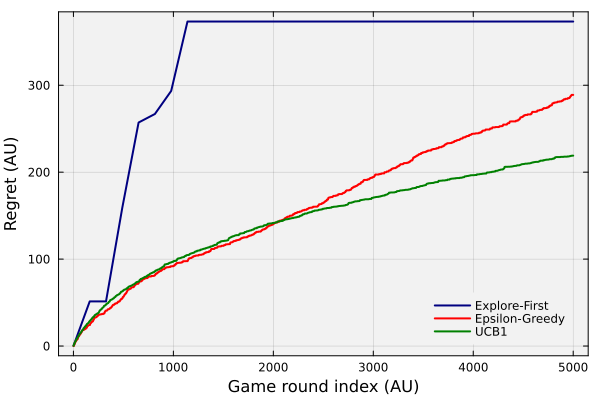

In [16]:
let

    # compute the regret
    R₁ = regret(results_explore_first);
    R₂ = regret(results_eps_greedy);
    R₃ = regret(results_UCB1);

    p = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);
    plot!(R₁, lw=2, label="Explore-First", c=:navy)
    plot!(R₂, lw=2, label="Epsilon-Greedy", c=:red)
    plot!(R₃, lw=2, label="UCB1", c=:green)
    xlabel!("Game round index (AU)", fontsize=18)
    ylabel!("Regret (AU)", fontsize=18)

end

### Theoretical regret bounds
Finally, let's compute the theoretical regret bounds for the algorithms we explored. These bounds help us understand the worst-case performance guarantees of each algorithm. Note that lower bounds indicate better theoretical performance (slower regret growth).

__Explore-First__: The expected regret over $T$ rounds is bounded by $\mathbb{E}\left[R(T)\right]\leq{T}^{2/3}\times\mathcal{O}\left(K\cdot\log{T}\right)^{1/3}$, scaling as $T^{2/3}$.


In [17]:
(T^(2/3))*(K*log(T))^(1/3)

1142.2947540395082

__Epsilon-Greedy__: The epsilon-greedy algorithm achieves a regret bound of $\mathbb{E}\left[R(T)\right]\leq{T}^{2/3}\cdot\left(K\cdot\log{T}\right)^{1/3}$, also scaling as $T^{2/3}$.


In [18]:
regret_eps_greedy = (T^(2/3))*(K*log(T))^(1/3)


1142.2947540395082

__UCB1__: The UCB1 algorithm achieves a regret bound of $\mathbb{E}\left[R(T)\right]\leq\mathcal{O}\left(\sqrt{KT\cdot\log{T}}\right)$, scaling as $\sqrt{T}$ - the best asymptotic performance.


In [19]:
sqrt(K*T*log(T))

545.9869611076517

___

## Summary
In this activity, we implemented and evaluated three fundamental bandit algorithms—explore-first, epsilon-greedy, and UCB1—on a stochastic multi-armed bandit problem with Beta-distributed rewards.

> __Key Takeaways:__
>
> 1. **Algorithm implementation and execution**: We built working implementations of explore-first, epsilon-greedy, and UCB1 algorithms, each with different strategies for balancing exploration and exploitation in sequential decision-making under uncertainty.
> 2. **Empirical regret analysis**: We computed and visualized regret curves for each algorithm, demonstrating how different approaches to the exploration-exploitation tradeoff lead to varying cumulative regret over time.
> 3. **Theoretical vs. practical performance**: We compared theoretical regret bounds with empirical results, showing how UCB1 achieves the best asymptotic performance while epsilon-greedy provides a good balance between simplicity and effectiveness.

These bandit algorithms provide practical tools for decision-making in uncertain environments, with UCB1 offering the strongest theoretical guarantees for long-term performance.
___